# SBI CMB lensing

In [15]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from classy import Class
import numpy as np
import camb
from camb import model
from CMB_lensing_SBI.cmb_lensing_sbi_pipe import *
import healpy as hp
from pixell import enmap
from pixell import curvedsky as cs
from pixell import enmap,lensing as plensing,curvedsky, utils, enplot
from orphics import io,maps
from falafel import qe
import re
import gc
from scipy.interpolate import interp1d

# some config -------------
path_files = '/pscratch/sd/j/jaejoonk/lensing_pipeline_data/'
outdir = '/pscratch/sd/m/mgatti/CMB_lensing_maps/'


beam_fwhm = 1.4


# maps config --------------
nside= 4096 # this is needed for the kappa map and the kappa_alm to lens the CMB maps. nside 1024 is good up to l ~2k., nside 4096 should pobably be our default here.
arcmin_res_car = 1# this somehow determines also the resolution of the CAR maps. can't be too small. 
lmax = 2500 #6000 is the default for the ACT pipeline; but we can't really do it as class can't generate lensing cls a l>2500 (unlensed ones, yes, so when we will use N-bdy sims it will be OK)



#### ACT configs -----------
data_maps_fn_pattern = 'sim_cmb_night_%s_%s_%s_3pass_1way_set%s_map.fits'
m = 'night'
a_f = ['pa4_f150','pa5_f090','pa5_f150','pa6_f090','pa6_f150']
qids = ['pa4av4', 'pa5av4', 'pa5bv4', 'pa6av4','pa6bv4'] 
array_dict = {'pa4av4': 'pa4_f150', 'pa5av4': 'pa5_f090', 'pa5bv4': 'pa5_f150','pa6av4': 'pa6_f090', 'pa6bv4': 'pa6_f150'}
gain_dict =  {
             "pa4_f150": 0.9708, "pa4_f220": 1.1119, "pa5_f090": 0.9625,
             "pa5_f150": 0.9961, "pa6_f090": 0.9660, "pa6_f150": 0.9764,
             }

pol_eff = {
            'pa4av4': 0.9584, 'pa5av4': 0.9646, 'pa5bv4': 0.9488,
            'pa6av4': 0.9789, 'pa6bv4': 0.9656
        }



global_folder = '/pscratch/sd/j/jaejoonk/lensing_pipeline_data/'
catalog_large = global_folder + 'catalog_large/union_catalog_large_20220316.csv'
catalog_regular = global_folder +'catalog_regular/union_catalog_regular_20220316.csv'
nemomodel_f090 = global_folder+ '/nemomodel_f090/nemomodel_dr6_all_clustersSNR5090down2.fits'
nemomodel_f150 = global_folder+ '/nemomodel_f150/nemomodel_dr6_all_clustersSNR5150down2.fits'
beams_path = global_folder+ '/beams_path/20230902/'
szbeam150 = global_folder+ '/szbeam150/s16_pa2_f150_nohwp_night_beam_tform_jitter.txt'
szbeam90 =  global_folder+ '/szbeam90/s16_pa3_f090_nohwp_night_beam_tform_jitter.txt'
calibration = global_folder+ 'calibration/tf_fit_dr6_%s_%s.dat'
kcoadded_alms=  'kcoadd_data_tszsub_%s_%s.fits'

nsplits = 1
sim_num = 1
data_run = False
model_subtract_tsz = False


# CONFIG COSMOLOGY

In [2]:
params = dict()
params['root']   = './'
params['output'] = 'dTk'
#params['nbody_gauge_transfer_functions'] = 'y'
params['P_k_max_h/Mpc']   = 100
        
#####LCDM parameter####
        
params['Omega_b']   = 0.049000
params['Omega_cdm'] = 0.268500
params['h']         = 0.671100
params['tau_reio']  = 0.054308
params['sigma8']    = 0.834000
params['n_s']       = 0.962400
params['Omega_fld'] = 0. #682500



#params['w0_fld']    = -1.
#params['Omega_Lambda']= 0.000



params['format']    = 'CAMB'

params['write primordial'] = 'yes'
params['write background'] = 'yes'
params['write parameters'] = 'yes'
params['write thermodynamics'] = 'yes'
params['write warnings'] = 'yes'
params['headers'] = 'yes'
        
#params['overwrite_root'] = 'y'
       
params['input_verbose'] = 1
params['background_verbose'] = 10
params['thermodynamics_verbose'] = 1
params['perturbations_verbose'] = 1
params['transfer_verbose'] = 1
params['primordial_verbose'] = 1
params['spectra_verbose'] = 1
params['nonlinear_verbose'] = 1
params['lensing_verbose'] = 1
params['output_verbose'] = 1
        
        
        
params['N_ur'] = 2.0328
params['N_ncdm'] = 1
params['deg_ncdm'] = 1
params['T_ncdm'] = 0.71611
        
        
########axion parameters#######
params['scf_potential'] = 'axion'
params['n_axion'] = 3.000000 #1

##one can pass either:
params['log10_axion_ac'] = -3.500000 #-3.531
params['fraction_axion_ac'] = 0.0001 #0.000100 #0.1

##one also needs to specify scf_param = phi_i, phi_ini_dot
params['scf_parameters'] = '2.7,0.' #1.5,0.0
########################

#####extra EDE parameters#####
#keep as is for standard runs#
##we do not use the fluid approximation##
params['scf_evolve_as_fluid'] = 'no' 	
#params['scf_evolve_as_fluid_always'] = 'no'
params['scf_evolve_like_axionCAMB'] = 'no'
params['do_shooting'] =  'yes'  ##controls overall shooting; useful when debugging
params['do_shooting_scf'] = 'yes' ##controls shooting for scf only; useful when debugging.
params['scf_has_perturbations'] = 'yes'
params['attractor_ic_scf'] ='no' 
params['compute_phase_shift'] = 'no' ##one can ask to compute the phase_shift imprinted by the EDE following Baumann et al. JCAP01(2016)007
params['loop_over_background_for_closure_relation']= 'yes' ##this is required because we do not necessarily know the value of Omega_EDE today and therefore the closure relation needs to be enforced otherwise. for the usual n=3 EDE this is not really relevant, but it may be for n=1.

####################################

#####precision parameters#####
#keep as is for standard runs#
params['adptative_stepsize'] = 1000
params['precision_newton_method_F'] = 1e-3   ####be careful when playing with these parameters if theta_s is shoot for (we recommend running on H for MCMC); but often required to be set to 1e-2 or 1e-3 for EDE shooting to converged.
params['precision_newton_method_x'] = 1e-3  ####be careful when playing with these parameters if theta_s is shoot for (we recommend running on H for MCMC); but often required to be set to 1e-2 or 1e-3 for EDE shooting to converged.
params['precision_loop_over_background'] = 1e-3 ### precision with which we will be enforcing the closure relation



###################################
params['z_max_pk'] = '100.'
params['lensing']= 'yes' 
params['output']= 'tCl,pCl,lCl,mPk'         
    
    
# COMPUTE TT EE BB POWER SPECTRA WITH CLASS ------------------------------------------------------------------------------------------------------------

# Initialize the CLASS cosmological model
cosmo = Class()
cosmo.set(params)  # Set the cosmological parameters; replace 'params' with your actual parameters
cosmo.compute()   # Compute the cosmological observables

# Get the lensed and unlensed CMB power spectra up to lmax
lensed_cls = cosmo.lensed_cl(min([lmax,2500])) 
unlensed_cls = cosmo.raw_cl(min([lmax,3000])) 


Reading input parameters
Computing unknown input parameters
 -> matched budget equations by adjusting Omega_Lambda = 6.824071e-01
 -> matched budget equations by adjusting Omega_Lambda = 6.824071e-01
 -> matched budget equations by adjusting Omega_Lambda = 6.824071e-01
 -> matched budget equations by adjusting Omega_Lambda = 6.824071e-01
 -> matched budget equations by adjusting Omega_Lambda = 6.824071e-01
 -> matched budget equations by adjusting Omega_Lambda = 6.824071e-01
 -> found alpha_squared = -4.514942e+00
 -> found power_of_mu = -3.591077e+00
 -> found A_s = 2.131800e-09
 -> matched budget equations by adjusting Omega_Lambda = 6.824071e-01
Running CLASS version v2.9.4
Computing background
 -> ncdm species i=1 sampled with 11 (resp. 5) points for purpose of background (resp. perturbation) integration. In the relativistic limit it gives Delta N_eff = 1.0132
 -> total N_eff = 3.046 (sumed over ultra-relativistic species, ncdm and dark radiation)
 -> non-cold dark matter species w

# CAMB settings

In [93]:
# Initialize CAMB parameters
# Initialize CAMB parameters
pars = camb.CAMBparams()

# Set cosmological parameters
pars.set_cosmology(H0=67.02393, ombh2=0.02219218, omch2=0.1203058, omk=0, tau=0.06574325)
pars.set_dark_energy(w=-1, cs2=1)
pars.InitPower.set_params(As=2.15086031154146e-9, ns=0.9625356, pivot_scalar=0.05)

# Set other cosmological parameters
pars.YHe = 0.2448964
pars.TCMB = 2.7255

# Set reionization parameters
pars.Reion.Reionization = True
pars.Reion.use_optical_depth = True
pars.Reion.optical_depth = 0.06574325
pars.Reion.delta_redshift = 0.5
pars.Reion.z_re_helium = 3.5
pars.Reion.z_start = 5.0

# Set scalar, tensor, and vector settings
pars.WantScalars = True
pars.WantTensors = False
pars.WantVectors = False

# Set accuracy parameters
pars.set_accuracy(AccuracyBoost=3, lAccuracyBoost=3)
pars.HighAccuracyDefault = True
pars.DoLateRadTruncation = True
pars.max_eta_k = 20000.0
pars.set_for_lmax(10000)#, lens_potential_accuracy=0)

# Set lensing and other related parameters
pars.WantLensing = True
pars.lensing_method = 1
pars.Alens = 1.0

# Set neutrino parameters
pars.num_massive_neutrinos = 1
pars.m_nu = [0.06]  
pars.nnu = 2.046  # Total number of effective neutrinos

# Set non-linear parameters
pars.NonLinear = model.NonLinear_both
pars.NonLinearModel.set_params(halofit_version='mead2020')  # Use 'mead2020' or other versions if preferred

# Set additional parameters from the ini file
pars.ombh2 = 0.02219218
pars.omch2 = 0.1203058
pars.omnuh2 = 0.00064
pars.scalar_spectral_index = [0.9625356]
pars.scalar_nrun = [0]
pars.scalar_nrunrun = [0]
pars.accurate_polarization = True
pars.accurate_reionization = True
pars.accurate_BB = False
pars.use_physical = True
pars.initial_condition = 1
pars.feedback_level = 1
pars.output_file_headers = True
pars.number_of_threads = 0
pars.use_spline_template = True
# Set Gaussian terms if needed (these seem to be related to reionization tuning)
# Commented out as they are typically not exposed directly in the Python API
# pars.AGauss1 = -0.14
# pars.AGauss2 = 0.079
# pars.zGauss1 = 7.28
# pars.zGauss2 = 6.73
# pars.wGauss1 = 0.18
# pars.wGauss2 = 0.33

# Set output filenames, though these are more relevant for file output
# pars.scalar_output_file = 'scalCls.dat'
# pars.lensed_output_file = 'lensedCls.dat'
# pars.lens_potential_output_file = 'lenspotentialCls.dat'


# Initialize the power spectrum
results = camb.get_results(pars)

# Get the CMB power spectra
powers = results.get_cmb_power_spectra(pars, CMB_unit=None, raw_cl=True)


In [95]:
lensed_cls1 = {'tt': powers['lensed_scalar'][:,0], 'te': powers['lensed_scalar'][:,3],
              'ee': powers['lensed_scalar'][:,1], 'bb': powers['lensed_scalar'][:,2],
              'pp': powers['lens_potential'][:,0]}


In [ ]:
camb_filename = '../data/cosmo2017_10K_acc3_params.ini'

# it's really this simple!
pars = camb.read_ini(camb_filename)
results = camb.get_results(pars)

# CMB_unit set to None to exclude ~1e12 factor,
# raw_cl to give me Cl not l(l+1)/2pi Cl
powers = results.get_cmb_power_spectra(pars, CMB_unit=None, raw_cl=True)


unlensed_cls = {'tt': powers['unlensed_scalar'][:,0], 'te': powers['unlensed_scalar'][:,3],
                'ee': powers['unlensed_scalar'][:,1], 'bb': powers['unlensed_scalar'][:,2]}

lensed_cls = {'tt': powers['lensed_scalar'][:,0], 'te': powers['lensed_scalar'][:,3],
              'ee': powers['lensed_scalar'][:,1], 'bb': powers['lensed_scalar'][:,2],
              'pp': powers['lens_potential'][:,0]}


In [ ]:
plt.plot(lensed_cls1['pp'][3:6000]/lensed_cls['pp'][3:6000])

# LET'S MAKE TT,EE,BB and KAPPA maps. Let's also lens TT,EE,BB

5.612861
    giving an angle 100*theta_* = 1.043621
 -> baryon drag stops at z = 1059.259728
    corresponding to conformal time = 286.165692 Mpc
    with comoving sound horizon rs = 147.192347 Mpc
 -> reionization  at z = 7.755692
    corresponding to conformal time = 5092.957446 Mpc
Computing sources
Computing primordial spectra (analytic spectrum)
Computing linear Fourier spectra.
 -> sigma8=0.8333 for total matter (computed till k = 106.737 h/Mpc)
 -> S8=0.85726 for total matter (computed till k = 106.737 h/Mpc) with Omega_m = 0.3175 
 -> sigma8=0.833333 for baryons+cdm  (computed till k = 106.737 h/Mpc)
 -> sigma_12 = 8.294843e-01 for total matter 
No non-linear spectra requested. Nonlinear calculations skipped.
Computing transfers
Computing unlensed harmonic spectra
Computing lensed spectra (fast mode)
Reading input parameters
Computing unknown input parameters
 -> matched budget equations by adjusting Omega_Lambda = 6.824071e-01
 -> matched budget equations by adjusting Omega_La

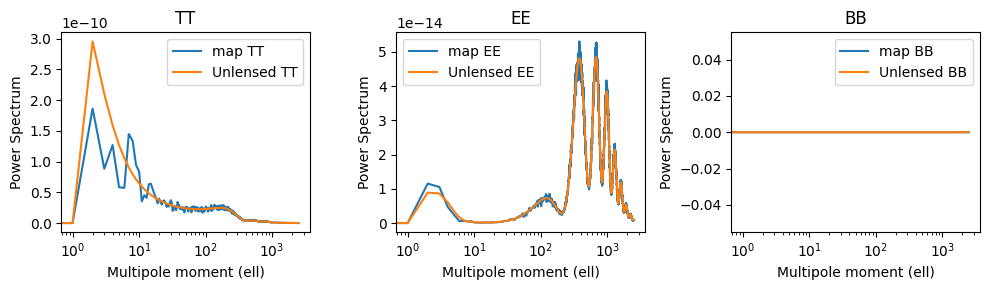

/tmp/ipykernel_1379514/2174019069.py:92: RuntimeWarning: divide by zero encountered in divide
  phi_cmb_alm = kappa_cmb_alm / (ell * (ell + 1) / 2)  # Calculate the lensing potential alms
/tmp/ipykernel_1379514/2174019069.py:92: RuntimeWarning: invalid value encountered in divide
  phi_cmb_alm = kappa_cmb_alm / (ell * (ell + 1) / 2)  # Calculate the lensing potential alms
/tmp/ipykernel_1379514/2174019069.py:130: RuntimeWarning: divide by zero encountered in divide
  axs[0].plot(ell[:lmax], T_cl[:lmax] / unlensed_cls['tt'][:lmax] , label='Unlensed TT')
/tmp/ipykernel_1379514/2174019069.py:131: RuntimeWarning: divide by zero encountered in divide
  axs[0].plot(ell[:lmax], cl_T_lensed_hp[:lmax] / unlensed_cls['tt'][:lmax] , label='Lensed TT')
/tmp/ipykernel_1379514/2174019069.py:132: RuntimeWarning: invalid value encountered in divide
  axs[0].plot(ell[:lmax], lensing_cls['tt'][:lmax]*f_beam**2 / unlensed_cls['tt'][:lmax] , label='CLASS Lensed TT')
/tmp/ipykernel_1379514/2174019069.py:13

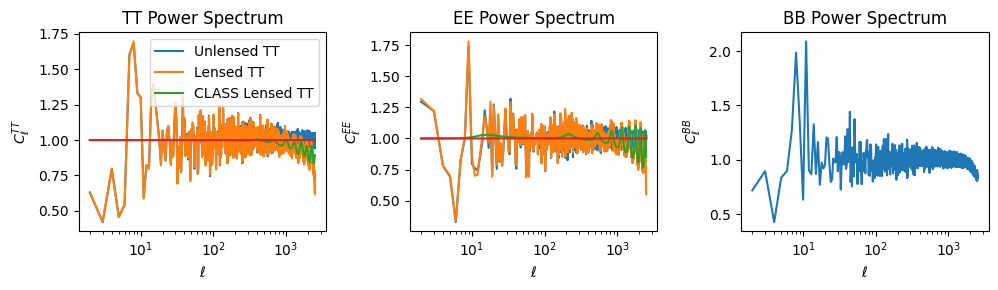

In [24]:
'''
Let's generate some TT,TE.. using CLASS (it will be useful in the long run).
I don't think it will matter for this test if these are all slightly different..

'''
    

# Generate TT, EE, EB, BB power spectra from unlensed alms
ps = np.array([[unlensed_cls['tt'], unlensed_cls['te'], 0 * unlensed_cls['te']],
               [unlensed_cls['te'], unlensed_cls['ee'], 0 * unlensed_cls['te']],
               [0 * unlensed_cls['tt'], 0 * unlensed_cls['te'], 0 * unlensed_cls['bb']]])

# Generate random alms (spherical harmonic coefficients) for the power spectra
alms_ = cs.rand_alm(ps, ainfo=None, lmax=lmax, seed=None, dtype=np.complex128, m_major=True, return_ainfo=False)

# Convert alms to Healpix maps
T_map = hp.alm2map(alms_[0], nside=nside)
E_map = hp.alm2map(alms_[1], nside=nside)
B_map = hp.alm2map(alms_[2], nside=nside)

# Compute the power spectra of the maps
T_cl = hp.anafast(T_map)
E_cl = hp.anafast(E_map)
B_cl = hp.anafast(B_map)

# Assuming T_cl, E_cl, B_cl, unlensed_cls, and lmax are defined
ell = np.arange(len(T_cl))




############################################################################################################
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Plot TT
axs[0].plot(T_cl[:lmax] * ell[:lmax], label='map TT')
axs[0].plot(unlensed_cls['tt'][:lmax] * ell[:lmax], label='Unlensed TT')
axs[0].set_xscale('log')
axs[0].set_title('TT')
axs[0].set_xlabel('Multipole moment (ell)')
axs[0].set_ylabel('Power Spectrum')
axs[0].legend()

# Plot EE
axs[1].plot(E_cl[:lmax] * ell[:lmax], label='map EE')
axs[1].plot(unlensed_cls['ee'][:lmax] * ell[:lmax], label='Unlensed EE')
axs[1].set_xscale('log')
axs[1].set_title('EE')
axs[1].set_xlabel('Multipole moment (ell)')
axs[1].set_ylabel('Power Spectrum')
axs[1].legend()

# Plot BB
axs[2].plot(B_cl[:lmax] * ell[:lmax], label='map BB')
axs[2].plot(unlensed_cls['bb'][:lmax] * ell[:lmax], label='Unlensed BB')
axs[2].set_xscale('log')
axs[2].set_title('BB')
axs[2].set_xlabel('Multipole moment (ell)')
axs[2].set_ylabel('Power Spectrum')
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
############################################################################################################



###### compute kappa and lens maps --------------------------------------------------

# Make a noiseless kappa map
ell_ = np.arange(len(lensed_cls['pp']))  # Define ell array for the power spectrum
kappa_cmb = hp.synfast((lensed_cls['pp'] * (ell_ * (ell_ + 1) / 2)**2), nside=nside, lmax=lmax)  # Generate kappa map using the lensing potential power spectrum


# Compute alms from the kappa map


kappa_cmb_alm = hp.map2alm(kappa_cmb,lmax=lmax)  # Convert kappa map to spherical harmonics coefficients (alms)
ell, emm = hp.Alm.getlm(lmax=lmax)  # Get ell and m values for the alms

# Convert kappa alms to phi alms (lensing potential)
phi_cmb_alm = kappa_cmb_alm / (ell * (ell + 1) / 2)  # Calculate the lensing potential alms
phi_cmb_alm[ell==0] = 1e-30
# Define the shape and WCS (World Coordinate System) for the map
shape, wcs = enmap.fullsky_geometry(res=np.deg2rad(arcmin_res_car/60.), proj="car")  # Set map resolution to 1 arcminute

# Generate lensed T, E, and B maps from the alms and lensing potential
maps_ = pixell.lensing.lens_map_curved((3, shape[0], shape[1]), wcs, phi_cmb_alm, alms_, phi_ainfo=None, maplmax=None, dtype=np.float64, spin=[0, 2], output="l", geodesic=True, verbose=False, delta_theta=None)

# Convert the lensed maps to alms
alm_TEB = pixell.curvedsky.map2alm(maps_[0], lmax=lmax, spin=[0, 2])



# Apply beam -----------------
alm_TEB[0] = cs.almxfl(alm_TEB[0], lambda ell: gauss_beam(ell, beam_fwhm))
alm_TEB[1] = cs.almxfl(alm_TEB[1], lambda ell: gauss_beam(ell, beam_fwhm))
alm_TEB[2] = cs.almxfl(alm_TEB[2], lambda ell: gauss_beam(ell, beam_fwhm))

# Compute the power spectra from the beam-applied alms
cl_T_lensed_hp = hp.alm2cl(alm_TEB[0])
cl_E_lensed_hp = hp.alm2cl(alm_TEB[1])
cl_B_lensed_hp = hp.alm2cl(alm_TEB[2])

# Convert the beam-applied alms back to maps
map_T_lensed_hp, map_E_lensed_hp, map_B_lensed_hp = hp.alm2map(alm_TEB, nside=nside, pol=False)

# Calculate the beam function for the given FWHM
tht_fwhm = np.deg2rad(beam_fwhm / 60.)
f_beam = np.exp(-(tht_fwhm**2) * (np.arange(lmax)**2) / (16 * np.log(2.)))




############################################################################################################

fig, axs = plt.subplots( 1,3, figsize=(10, 3))

# TT plot
axs[0].plot(ell[:lmax], T_cl[:lmax] / unlensed_cls['tt'][:lmax] , label='Unlensed TT')
axs[0].plot(ell[:lmax], cl_T_lensed_hp[:lmax] / unlensed_cls['tt'][:lmax] , label='Lensed TT')
axs[0].plot(ell[:lmax], lensing_cls['tt'][:lmax]*f_beam**2 / unlensed_cls['tt'][:lmax] , label='CLASS Lensed TT')
axs[0].plot(ell[:lmax], unlensed_cls['tt'][:lmax] / unlensed_cls['tt'][:lmax] )
axs[0].set_xscale('log')
axs[0].set_title('TT Power Spectrum')
axs[0].set_xlabel(r'$\ell$')
axs[0].set_ylabel(r'$C_\ell^{TT}$')
axs[0].legend()

# EE plot
axs[1].plot(ell[:lmax], E_cl[:lmax] / unlensed_cls['ee'][:lmax], label='Unlensed EE')
axs[1].plot(ell[:lmax], cl_E_lensed_hp[:lmax] / unlensed_cls['ee'][:lmax], label='Lensed EE')
axs[1].plot(ell[:lmax], lensing_cls['ee'][:lmax]*f_beam**2 / unlensed_cls['ee'][:lmax], label='CLASS Lensed EE')
axs[1].plot(ell[:lmax], unlensed_cls['ee'][:lmax] / unlensed_cls['ee'][:lmax], label='Reference')
axs[1].set_xscale('log')
axs[1].set_title('EE Power Spectrum')
axs[1].set_xlabel(r'$\ell$')
axs[1].set_ylabel(r'$C_\ell^{EE}$')


# BB plot
axs[2].plot(ell[:lmax], cl_B_lensed_hp[:lmax] / lensing_cls['bb'][:lmax]/f_beam**2 , label='Lensed BB')
axs[2].set_xscale('log')
axs[2].set_title('BB Power Spectrum')
axs[2].set_xlabel(r'$\ell$')
axs[2].set_ylabel(r'$C_\ell^{BB}$')

# Adjust layout
plt.tight_layout()
plt.show()


############################################################################################################


# Let's add noise and create multiple channels

This will automatically make 0.5' maps; it's in the mask wcs

In [10]:
# Define paths to the mask and noise simulation files
mask_path = path_files + "/mask/act_mask_fejer1_20220316_GAL070_rms_70.00_downgrade_None.fits"
noise_path = '/noise_sims_path/noise_sims/'

# Read the mask map
mask = enmap.read_map(mask_path)




# Create an empty map to fill with noise
full_shape, full_wcs = mask.shape, mask.wcs
imap = enmap.empty((3,) + full_shape, full_wcs, dtype=np.float32)

# Convert the alms to a map, convolved with the beam
sigmap_conv = cs.alm2map(alm_TEB, imap)

# Apply the mask to the map (set regions with mask < 0.25 to 0)
sigmap_conv[:, mask < 0.25] = 0

# Handle NaN values in the map (set them to 0)
sigmap_conv[np.isnan(sigmap_conv)] = 0

# Plot the temperature (T) map
plt.figure(figsize=(10, 5))
plt.imshow(np.array(sigmap_conv[0].data))  # Plot the T map
plt.title('T map (no noise + beam + mask)')
plt.colorbar(label='Intensity')
plt.show()

NameError: name 'alm_TEB' is not defined

I created a mnms_config.yaml file in my home directory specifying the path in my pscratch of models & sims. 
I have then copied the models from
/global/cfs/cdirs/cmb/data/act_dr6/dr6.01/simulations/noise/models/
to
/pscratch/sd/m/mgatti/CMB_lensing/mnmm_prod/models/

and I can then generate my own noise sims!

In [13]:

qids_

['pa4a', 'pa5a', 'pa5b', 'pa6a', 'pa6b']

In [25]:
import sys
sys.path.append('/global/homes/m/mgatti')
from mnms import noise_models as nm
import os
os.environ['SOFIND_SYSTEM'] = 'perlmutter'

# a qid is an identifier tag for a dataset, like a detector array.
# see sofind for a list of possible qids depending on which data
# model you load. thus, in the below, could also do ['pa4a', 'pa4b'] 
# or ['pa6a', 'pa6b']
qids_ = ['pa5a', 'pa5b'] 
#qids_ = ['pa6b']#, 'pa5b'] 
#qids_ = np.array([q[:-2] for q in qids])
# this will load a baseline-map noise model for act_dr6v4. could also 
# do (for example) 'act_dr6v4_pwv_split' for pwv split maps (likewise el_split, inout_split), or `act_dr6.01` for dr6.01 products. these
# correspond to the name of noise_model config files in the noise_model
# product of sofind
config_name = 'act_dr6v4' 

# this will load the tiled noise model. could also do 'fdw_cmbmask'
# for directional wavelet model (or 'tile', 'wav', or 'fdw' for
# dr6.01; see noise_models product configs in sofind). these correspond
# to the blocks within the config file
noise_model_name = 'fdw_cmbmask'


# if you are loading a config that requires subproduct_kwargs (e.g.,  
# 'act_dr6v4_pwv_split' maps require a 'pwv_split' argument), you need
# to specify which subproduct_kwargs the model will include at object
# creation. this could be nothing (e.g., for 'act_dr6v4'),
# {'pwv_split': ['pwv1']} (e.g, for 'act_dr6v4_pwv_split'), or may be
# a longer list like {'inout_split': ['inout1', 'inout2']} (e.g., for
# 'act_dr6v4_inout_split'). in the latter case, passing a pair of qids
# will result in 4 "datasets" (the outer product of all the qids and
# subproduct_kwargs in the list) being jointly modeled/covaried.
subproduct_kwargs = {}
# subproduct_kwargs = {'inout_split': ['inout1', 'inout2']}

# instantiate NoiseModel object
tnm = nm.BaseNoiseModel.from_config(
    config_name,
    noise_model_name,
    *qids_,
    **subproduct_kwargs
    )

# grab a sim from disk, generate on-the-fly if does not exist
my_sim = tnm.get_sim(split_num=2, sim_num=16, lmax=10800,check_on_disk=True)#, generate=True)

## grab a sim from disk, fail if does not exist on-disk
#my_sim = tnm.get_sim(split_num=2, sim_num=16, lmax=10800, generate=False)
#
## generate a sim on-the-fly whether or not exists on disk
#my_sim = tnm.get_sim(split_num=2, sim_num=16, lmax=10800, check_on_disk=False)

Sim split_num 2, sim_num 16, lmax 10800, alm False not found on-disk, generating instead


FileNotFoundError: Model for split_num 2, lmax 10800 not found on-disk, please generate it first

In [ ]:
/global/cfs/cdirs/cmb/data/act_dr6/dr6.01/simulations/noise/sims
/global/cfs/cdirs/act/data/act_dr6v4/simulations/noise/models/act_dr6v4_fdw_cmbmask_pa5_f090_pa5_f150_lmax10800_4way_set2_noise_model.hdf5



In [5]:
from mnms import noise_models as nm, utils_nm
from sofind import utils as s_utils
config_fn = utils_nm.get_mnms_fn('act_dr6.01_cmbmask.yaml', 'configs')
config_dict = s_utils.config_from_yaml_file(config_fn)
print(yaml.safe_dump(config_dict))


ImportError: cannot import name 'utils_nm' from 'mnms' (/global/homes/m/mgatti/.conda/envs/cmb_lensing_env/lib/python3.8/site-packages/mnms/__init__.py)

In [19]:
qids_ =  ['pa5b'] 
config_name

'act_dr6v4'

In [20]:
tnm = nm.TiledNoiseModel.from_config('act_dr6.01_cmbmask', 'pa5a', 'pa5b')


#tnm = nm.TiledNoiseModel.from_config(
#    config_name,
#   # noise_model_name,
#    *qids_,
#    **subproduct_kwargs
#    )
#

KeyError: 'pa5a'

In [8]:
from mnms import noise_models as nm

In [6]:


totmap_dict = dict()


for split in range(nsplits):
    for i,af in enumerate(a_f):

        #froot = "/home/s/sievers/kaper/scratch/maps/dr6v4_20230316/" #'/home/s/sievers/kaper/scratch/maps/dr6v3_20211031/'
        #fname = f"{froot}cmb_{m}_{af}_3pass_4way_coadd_ivar.fits" #f"{froot}cmb_{m}_{a}_{f}_8way_coadd_ivar.fits"
        #ivar = enmap.read_map(fname)

        ivar = 10000000.*np.ones((3,)+full_shape)
        seed = int(i)+5
        wn_map = white_noise((3,)+full_shape,full_wcs,seed = seed,div=ivar)
        totmap = (sigmap_conv+wn_map)
        totmap[:,mask<0.25] = 0 
        totmap[np.isnan(totmap)] = 0
        totmap_dict[af] = totmap

        #'''
        
        #? coadd vs split? how to change this?
        enmap.write_map(f"{outdir}sim_cmb_{m}_{af}_{sim_num}_3pass_1way_set{split}_ivar.fits",ivar)
        enmap.write_map(f"{outdir}sim_cmb_{m}_{af}_{sim_num}_3pass_1way_coadd_ivar.fits",ivar)
        enmap.write_map(f"{outdir}sim_cmb_{m}_{af}_{sim_num}_3pass_1way_set{split}_map_srcfree.fits",totmap)
        enmap.write_map(f"{outdir}sim_cmb_{m}_{af}_{sim_num}_3pass_1way_coadd_map_srcfree.fits",totmap)
        #'''

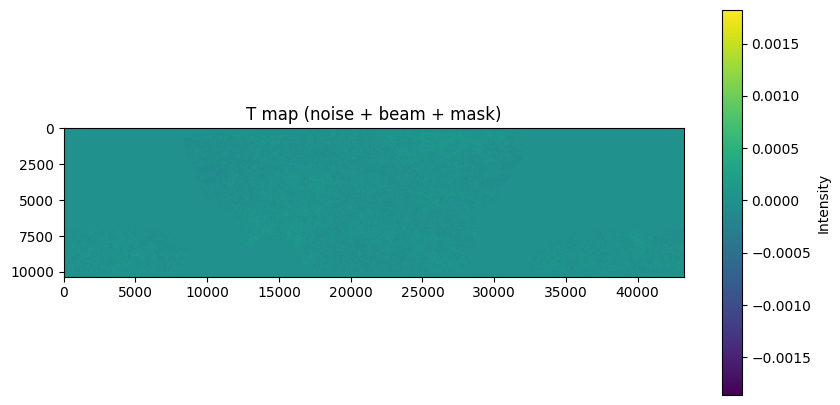

In [7]:
#############################
plt.figure(figsize=(10, 5))
plt.imshow(np.array(totmap_dict[af][0].data))#, grid=False)
plt.title('T map (noise + beam + mask)')
plt.colorbar(label='Intensity')
plt.show()

# downgrade

Sect 5.1 [https://arxiv.org/pdf/2304.05202]

The sky maps are produced at a resolution of 0.5′
but because our lensing reconstruction uses a maximum
CMB multipole of ℓmax = 3000, a downgraded pixel
resolution of 1′ is sufficient for the unbiased recovery
of the lensing power spectrum and reduces computation
time. Therefore, we downgrade the CMB data maps
by block-averaging neighbouring CMB pixels. Similarly,
the inverse-variance maps are downgraded by summing
the contiguous full-resolution inverse-variance values.




we're also doing the stacking of different splits:

Sect 5.6 [https://arxiv.org/pdf/2304.05202]

We first define for each array-frequency’s data the
map-based coadd map c, an unbiased estimate of the
sky signal, by taking the inverse-variance-weighted average of the eight split maps m_i


(Note we should also create 4 coadd-split maps, coadding  together split j and j + 4 with
j ∈ {0, 1, 2, 3})


NOISE


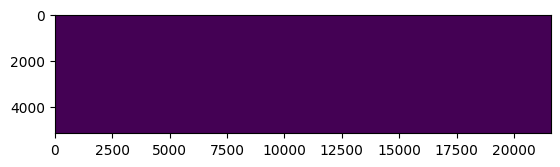

signal


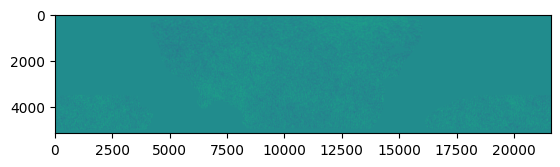

noise


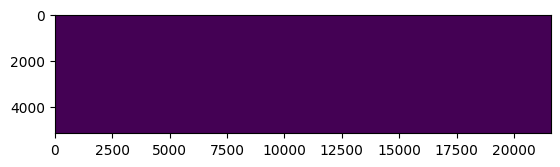

signal


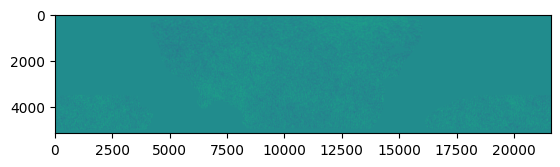


NOISE


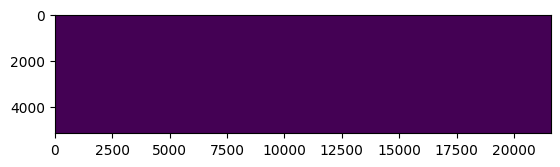

signal


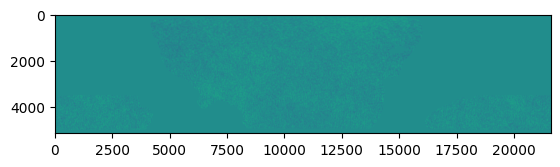

noise


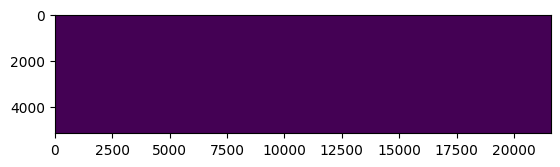

signal


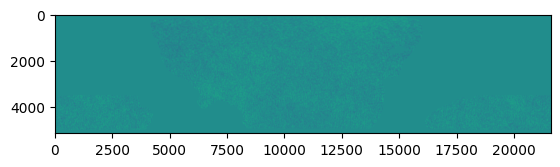


NOISE


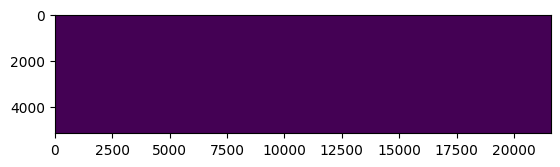

signal


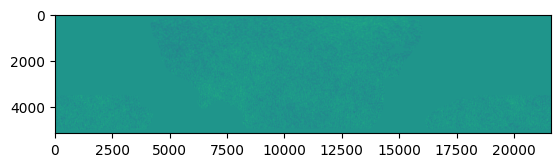

noise


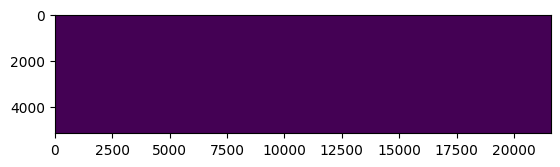

signal


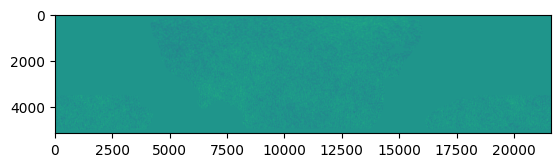


NOISE


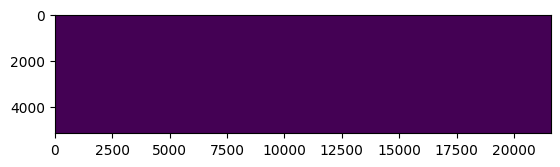

signal


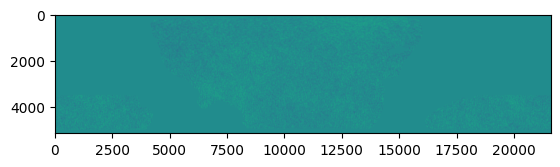

noise


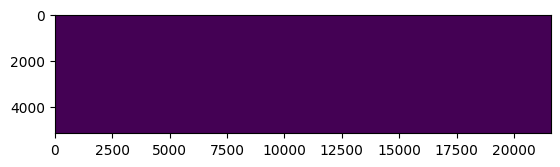

signal


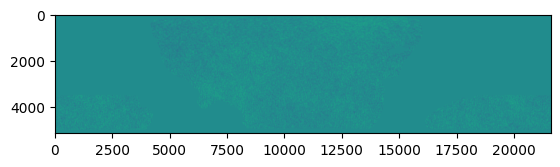


NOISE


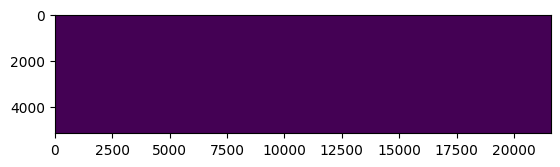

signal


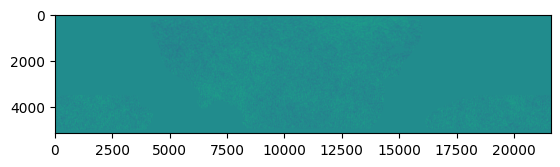

noise


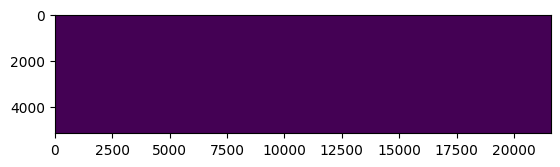

signal


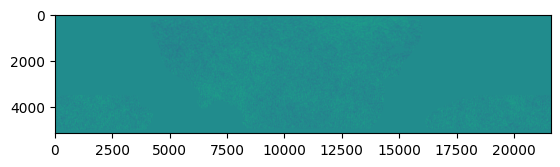

In [8]:
calibrated = True

for qid in qids:
    print ('')
    # get frequencies --------
    array_freq = array_dict[qid]
    array = array_freq[:3]
    freq = array_freq[4:]
    
    
    # NOISE MAPS --------------------
    stack = []
    for sset in np.arange(nsplits):
        ivarfn = re.sub("_map", "_ivar", data_maps_fn_pattern) % (array, freq, sim_num,split)
        mul = 1. / gain_dict[array_dict[qid]] if calibrated else 1.
        omap = enmap.read_map(outdir+ivarfn) * mul
        stack.append(omap)
    smap = enmap.enmap(np.stack(stack), omap.wcs)
    smap_downgraded = enmap.downgrade(smap, 2, op = np.sum)
    enmap.write_map(outdir+'/map_downgraded_ivar_{0}_{1}_{2}'.format(array,freq,sim_num), smap_downgraded)
        
    print ('NOISE')
    plt.imshow(smap_downgraded[0,0,:,:])
    plt.show()
    
    # DATA + NOISE MAPS ------------
    stack = []
    for sset in np.arange(nsplits):
        ivarfn = re.sub("_map", "_map_srcfree", data_maps_fn_pattern) % (array, freq, sim_num,split)
        mul = 1. / gain_dict[array_dict[qid]] if calibrated else 1.
        omap = enmap.read_map(outdir+ivarfn) * mul
        stack.append(omap)
    smap = enmap.enmap(np.stack(stack), omap.wcs)
    smap_downgraded = enmap.downgrade(smap, 2, op = np.sum)
    enmap.write_map(outdir+'/map_downgraded_srcfree_{0}_{1}_{2}'.format(array,freq,sim_num), smap_downgraded)
          
    print ('signal')
    plt.imshow(smap_downgraded[0,0,:,:])   
    plt.show()
    
    # coadd ----------------------------------
    ivarfn = re.sub("set%s_map", "coadd_ivar", data_maps_fn_pattern) % (array, freq, sim_num)
    mul = 1. / gain_dict[array_dict[qid]] if calibrated else 1.
    omap = enmap.read_map(outdir+ivarfn) * mul
    smap_downgraded = enmap.downgrade(omap, 2, op = np.sum)
    enmap.write_map(outdir+'/map_downgraded_coadd_ivar_{0}_{1}_{2}'.format(array,freq,sim_num), smap_downgraded)
    
    
    print ('noise')
    plt.imshow(smap_downgraded[0,:,:])  
    plt.show()
    
    ivarfn = re.sub("set%s_map", "coadd_map_srcfree", data_maps_fn_pattern) % (array, freq, sim_num)
    mul = 1. / gain_dict[array_dict[qid]] if calibrated else 1.
    omap = enmap.read_map(outdir+ivarfn) * mul
    smap_downgraded = enmap.downgrade(omap, 2, op = np.sum)
    enmap.write_map(outdir+'/map_downgraded_coadd_srcfree_{0}_{1}_{2}'.format(array,freq,sim_num), smap_downgraded)
    
    print ('signal')
    plt.imshow(smap_downgraded[0,:,:])  
    plt.show()

# inpaint

Sect 5.2 [https://arxiv.org/pdf/2304.05202]


As described in Section 3.5, we work with
maps in which point sources above a threshold of roughly
4–10 mJy (corresponding to an SNR threshold of 4σ)
have been fit and subtracted at the map level.

However,
very bright and/or extended sources may still have residuals in these maps. To address this, we prepare a catalog
of 1779 objects for masking with holes of radius 6′
: these
include especially bright sources that require a specialized point-source treatment in the map-maker (see Aiola
et al. 2020; Naess et al. 2020), extended sources with
SNR > 10 identified through cross-matching with external catalogs, all point sources with SNR > 70 at f150
and an additional list of locations with residuals from
point-source subtraction that were found by visual inspection. We include an additional set of 14 objects for
masking with holes of radius 10′
: these are regions of
diffuse or extended positive emission identified by eye
in matched-filtered co-adds of ACT maps. They include nebulae, Galactic dust knots, radio lobes and large
nearby galaxies.

We subsequently inpaint these holes using a constrained Gaussian realisation with a Gaussian
field consistent with the CMB signal and noise of the
CMB fields and matching the boundary conditions at
the hole’s edges

In [9]:
mask_path = path_files + "/mask/act_mask_fejer1_20220316_GAL070_rms_70.00_downgrade_3dg.fits"
mask = enmap.read_map(mask_path)
shape, wcs = mask.shape, mask.wcs

lras,ldecs = np.loadtxt(catalog_large,unpack=True,delimiter=',')
rras,rdecs = np.loadtxt(catalog_regular,unpack=True,delimiter=',')
lcoords = np.asarray((ldecs,lras))
rcoords = np.asarray((rdecs,rras))
lrad = 10.0
rrad = 6.0
mask1 = maps.mask_srcs(shape,wcs,lcoords,lrad)
mask2 = maps.mask_srcs(shape,wcs,rcoords,rrad)

jmask = mask1 & mask2
jmask = ~jmask




In [10]:
for qid in qids:
    # get frequencies --------
    array_freq = array_dict[qid]
    array = array_freq[:3]
    freq = array_freq[4:]
    
    # do it for the stacked maps ------------------------------------------------
    ivar_map = enmap.read_map(outdir+'/map_downgraded_ivar_{0}_{1}_{2}'.format(array,freq,sim_num))
    sig_map = enmap.read_map(outdir+'/map_downgraded_srcfree_{0}_{1}_{2}'.format(array,freq,sim_num))
    sig_map[...,mask<0.25]=0.0 ##intial maps had been masked (before downgrading) -- maybe delete here --- do we have to mask with new inpainting??
    ivar_map[...,mask<0.25]=0.0
    ip_map = gapfill_edge_conv_flat(sig_map, jmask,ivar=ivar_map) #make sure everything is getting inpainted
    ip_map[...,mask<0.25]=0.0
    enmap.write_map(outdir+'/map_downgraded_srcfree_inpainted_{0}_{1}_{2}'.format(array,freq,sim_num),ip_map)
    del ip_map
    del ivar_map
    gc.collect()
    
    # do it for the coadded maps -------------------------------------------------
    ivar_map = enmap.read_map(outdir+'/map_downgraded_coadd_ivar_{0}_{1}_{2}'.format(array,freq,sim_num))
    sig_map = enmap.read_map(outdir+'/map_downgraded_coadd_srcfree_{0}_{1}_{2}'.format(array,freq,sim_num))
    sig_map[...,mask<0.25]=0.0 ##intial maps had been masked (before downgrading) -- maybe delete here --- do we have to mask with new inpainting??
    ivar_map[...,mask<0.25]=0.0
    ip_map = gapfill_edge_conv_flat(sig_map, jmask,ivar=ivar_map) #make sure everything is getting inpainted
    ip_map[...,mask<0.25]=0.0
    enmap.write_map(outdir+'/map_downgraded_coadd_srcfree_inpainted_{0}_{1}_{2}'.format(array,freq,sim_num),ip_map)
    del ip_map
    del ivar_map
    gc.collect()

/global/homes/m/mgatti/.conda/envs/cmb_lensing_env/lib/python3.8/site-packages/CMB_lensing_SBI/cmb_lensing_sbi_pipe.py:91: RuntimeWarning: divide by zero encountered in divide
  return np.random.standard_normal(shape) / np.sqrt(div)
/global/homes/m/mgatti/.conda/envs/cmb_lensing_env/lib/python3.8/site-packages/CMB_lensing_SBI/cmb_lensing_sbi_pipe.py:91: RuntimeWarning: divide by zero encountered in divide
  return np.random.standard_normal(shape) / np.sqrt(div)
/global/homes/m/mgatti/.conda/envs/cmb_lensing_env/lib/python3.8/site-packages/CMB_lensing_SBI/cmb_lensing_sbi_pipe.py:91: RuntimeWarning: divide by zero encountered in divide
  return np.random.standard_normal(shape) / np.sqrt(div)
/global/homes/m/mgatti/.conda/envs/cmb_lensing_env/lib/python3.8/site-packages/CMB_lensing_SBI/cmb_lensing_sbi_pipe.py:91: RuntimeWarning: divide by zero encountered in divide
  return np.random.standard_normal(shape) / np.sqrt(div)
/global/homes/m/mgatti/.conda/envs/cmb_lensing_env/lib/python3.8/sit

# kspace_coadd 


so for each channel, the code :
subtract tsz profiles (this only works for data, for sims is set to False)
for each noise split, it deconvolves the beam
it applies some mask in k-space (this part is not clear to me, why is this necessary?
it estimates the noise from the data itself (this is also not clear to me, why is this needed? )
it corects the alms by some calibration (also this is not clear to me, where can I find more details?)
it ends up with a coaddition

In [ ]:
# some explanations of every step ~~~~~~~~~~~~

5.4. Pixel window deconvolution [https://arxiv.org/pdf/2304.05202] -------------------------------------------------------

The block averaging operation used to downgrade the
sky maps from 0.5′ to 1′ convolves the downgraded map
with a top-hat function that needs to be deconvolved.1

#####################

5.5. Fourier-space mask [https://arxiv.org/pdf/2304.05202] -------------------------------------------------------

Contamination by ground, magnetic, and other types
of pick up in the data due to the scanning of the ACT
telescope manifests as excess power at constant declination stripes in the sky maps and thus can be localised in
Fourier space We mask Fourier modes with |ℓx| < 90
and |ℓy| < 50 to remove this contamination as in Louis
et al. (2017); Choi et al. (2020).

We demonstrate in Appendix D that this Fouriermode masking reduces the recovered lensing signal by
around 10%; we account for this well-understood effect
with a multiplicative bias correction obtained from simulations.

#######################

5.6 Co-addition and noise model  [https://arxiv.org/pdf/2304.05202] -------------------------------------------------------





can we leave this uncalibrated?

In [49]:
mask_path = path_files + "/mask/act_mask_fejer1_20220316_GAL070_rms_70.00_downgrade_3dg.fits"
mask = enmap.read_map(mask_path)


sz_nemo = {}
sz90=enmap.read_map(nemomodel_f090)
sz_nemo["f090"] = sz90
sz150=enmap.read_map(nemomodel_f150)
sz_nemo["f150"] = sz150


all_maps = []
all_ivars = []
beam_fns = []
specs = ['I','Q','U'] # I believe these must be TEB
nspecs = len(specs)
nqids = len(qids)
nalms = get_nalms(lmax, lmax)
noise_specs = np.zeros((nspecs, nqids, lmax+1), dtype = np.float64)
coadded_alms_specs = np.zeros((nspecs, nqids, nalms), dtype=np.complex128)



for q,qid in enumerate(qids):
    
    # get frequenies
    array_freq = array_dict[qid]
    array = array_freq[:3]
    freq = array_freq[4:]
    

    # get beam function COADD -------------------------------
    fn = f"{beams_path}coadd_{array}_{freq}_night_beam_tform_jitter_cmb.txt"
    #fn = f"{self.beams_path}set{splitnum}_{array}_{freq}_night_beam_tform_jitter_cmb.txt"
    ls, bells = np.loadtxt(fn, unpack=True, usecols=[0, 1])
    bells = bells / bells[0]
    beam_q = interp1d(ls, bells, bounds_error=False, fill_value=0)
    beam_fns.append(beam_q)    
    
    
    
    # this load the stacked nsplits ----------------------
    map_splits = enmap.read_map(outdir+'/map_downgraded_srcfree_inpainted_{0}_{1}_{2}'.format(array,freq,sim_num))
    ivar_splits = enmap.read_map(outdir+'/map_downgraded_ivar_{0}_{1}_{2}'.format(array,freq,sim_num))

    
        
    # get SZ BEAM --------------------------------------------------
    this_beam = szbeam150 if freq == "f150" else szbeam90
    ls, bells = np.loadtxt(this_beam, unpack=True, usecols=[0, 1])
    bells = bells / bells[0]
    sz_beam =  interp1d(ls, bells, bounds_error=False, fill_value=0)

    # subtract the foreground map ----------------------------------
    if model_subtract_tsz:
        foreground = reconvolve_maps(sz_nemo[freq],mask,sz_beam,beam_q)
        for j in range(len(map_splits)):
            map_splits[j][0] = map_splits[j][0] - foreground #only subtract foreground from T map

        
    all_maps.append(map_splits)
    all_ivars.append(ivar_splits)
    dec_maps = [] #deconvolved beam, pixell window and kspace filter
    dec_ivars = [] #assoc ivars of decon maps (ivars are not deconvolved)

    
    
    # deconvolve beam ----------------------------------------------
    # Pixel window deconvolution, 5.4. [https://arxiv.org/pdf/2304.05202]
    for sp in range(nsplits):
        if data_run:
            fn = f"{beams_path}set{sp}_{array}_{freq}_night_beam_tform_jitter_cmb.txt"
            ls, bells = np.loadtxt(fn, unpack=True, usecols=[0, 1])
            bells = bells / bells[0]
            this_beam = interp1d(ls, bells, bounds_error=False, fill_value=0)
            smap = deconvolve_maps(map_splits[sp],mask,this_beam,lmax=6000)
        else:
            alm = cs.map2alm(map_splits[sp],lmax=6000)
            alm_decon = cs.almxfl(alm,lambda ell:1/gauss_beam(ell,beam_fwhm))
            imap = enmap.empty((3,)+mask.shape,mask.wcs,dtype=np.float32)
            smap = cs.alm2map(alm_decon,imap)
        dmap = kspace_mask(smap,vk_mask=[-1*90,90], hk_mask=[-1*50,50],deconvolve=True)
        
        
        # apply some mask in k-space  --------------------------------
        k_mask=mask_kspace(imap.shape,imap.wcs,lxcut=90,lycut=50)
        maps.filter_map(imap,k_mask)

        dec_maps.append(dmap)
        dec_ivars.append(ivar_splits[sp])
        
        
    # estimate data noise --------------------------------
    bls=interp1d(np.arange(lmax),np.ones(lmax),bounds_error=False,fill_value=0)
    for ispec,spec in enumerate(specs):
        noisecl= get_datanoise(dec_maps,dec_ivars, ispec, ispec, mask,bls,beam_deconvolve=False,N=1,lmax =lmax)
        bin_edges = np.linspace(2,len(noisecl),300).astype(int)
        cents,cls=bandedcls(noisecl,bin_edges)
        cls=maps.interp(cents,cls)(np.arange(len(noisecl)))
        noise_specs[ispec, q] = cls
        np.savetxt(outdir + '/1dweights_map_noise_{0}_{1}.txt'.format(qids[q],spec),cls)
        
        
        
    # is this the multiplicative bias from k_space cutting? ---
    ells_cal, cal = np.loadtxt(f"{calibration%(array,freq)}",unpack=True)
    cal = np.interp(np.arange(lmax),ells_cal,cal)

    
    # not clear here what to do
    noise = dec_maps[nsplits-1]
    
    
    # coadd
    #dec_splits = dec_maps
    #imap = enmap.zeros(dec_splits[0].shape,wcs=dec_splits[0].wcs)
    #ivarreff = enmap.zeros(dec_ivars[0].shape,wcs=dec_ivars[0].wcs)
    #for j in range(len(dec_ivars)):
    #    imap += dec_ivars[j]*dec_splits[j]
    #    ivarreff += dec_ivars[j]
    #noise = imap/ivarreff
    
    noise[~np.isfinite(noise)] = 0
    alms=cs.map2alm(noise,lmax=lmax)
    almsTcal=cs.almxfl(alms[0],1/cal)
    almsQcal=alms[1]/pol_eff[qids[q]]
    almsUcal=alms[2]/pol_eff[qids[q]]
    coadded_alms_specs[0,q]=almsTcal
    coadded_alms_specs[1,q]=almsQcal
    coadded_alms_specs[2,q]=almsUcal

    
    
    
dummy_beam = np.ones(noise_specs[0].shape) # Map already beam-deconvolved
f_shape = all_maps[0][0][0].shape
f_wcs = all_maps[0][0][0].wcs

kcoadd_I = kspace_coadd(coadded_alms_specs[0], dummy_beam, noise_specs[0])
kcoadd_Q = kspace_coadd(coadded_alms_specs[1], dummy_beam, noise_specs[1])
kcoadd_U = kspace_coadd(coadded_alms_specs[2], dummy_beam, noise_specs[2])
kcoadd = cs.alm2map(np.array([kcoadd_I, kcoadd_Q, kcoadd_U]), enmap.empty((3,) + f_shape, f_wcs))
#imap = enmap.empty(f_shape,f_wcs)
#omap = cs.alm2map(kcoadd_I,imap)
#io.plot_img(omap,down=8,filename=f"{LC.kcoadd_path}kcoadd_I.png")
#enplot.write("/home/s/sievers/kaper/scratch/lenspipe/sim_run/kcoadd/kcoadd0",enplot.plot(kcoadd[0]))

#this doesn't work :()
#Ealm,Balm=simgen.pureEB(kcoadd[1],kcoadd[2],mask,returnMask=0,lmax=LMAX,isHealpix=False)
#a=cs.alm2map(np.array([kcoadd_I,Ealm,Balm]),enmap.empty((3,)+f_shape,f_wcs))
k_alms=cs.map2alm(kcoadd,lmax=lmax).astype('complex64')
#k_alms=k_alms.astype(np.complex128)  ##This breaks my code!!!!

if model_subtract_tsz:
    tszsub = True
else:
    tszsub = False
#if args.coadd:
#    coadd_type = "coadded"
#else:
coadd_type = 0 #f"{args.split}"


outfn = f"{outdir}{kcoadded_alms%(tszsub,coadd_type)}"
hp.write_alm(outfn,k_alms,overwrite=True)

print("DONE ------")


ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but we are taking this into account 
0
generating alms
0.3041277154737765
ignore warning: some ivars are 0 but 

/tmp/ipykernel_2030105/2205946572.py:9: RuntimeWarning: divide by zero encountered in divide
  denom = np.sum(lbeams**2 / noise,axis=0)
/tmp/ipykernel_2030105/2205946572.py:11: RuntimeWarning: divide by zero encountered in divide
  weighted_alms=hp.almxfl(map_alms[i],lbeams[i]/noise[i])


DONE ------


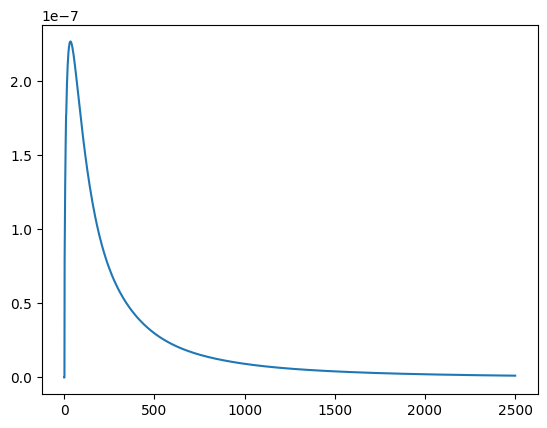

In [28]:
ell_ = np.arange(len(lensing_cls['pp']))  # Define ell array for the power spectrum
kappa_cmb = lensing_cls['pp'] * (ell_ * (ell_ + 1) / 2)**2
plt.plot(kappa_cmb)

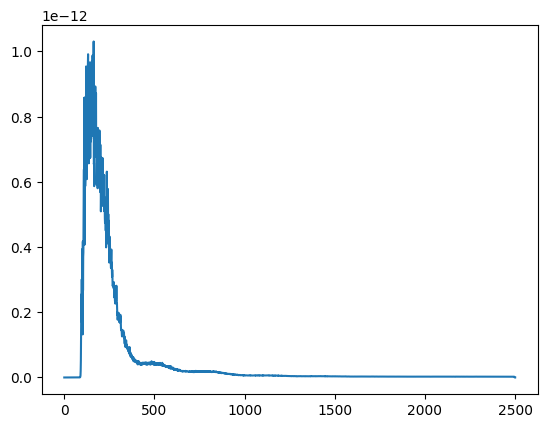

In [51]:
plt.plot(hp.alm2cl(k_alms[0].astype('complex128')))

# more simulated maps ~~

In [ ]:
#!/bin/bash

#SBATCH --nodes=20
#SBATCH --time=23:59:59
#SBATCH --ntasks-per-node=2
#SBATCH --cpus-per-task=40
#SBATCH --job-name=lensing_pipe
#SBATCH -o /home/s/sievers/kaper/scratch/lenspipe/output_sh/lensing_pipe_full_%j.out
#SBATCH -e /home/s/sievers/kaper/scratch/lenspipe/output_sh/lensing_pipe_full_%j.err
#SBATCH --mail-type=ALL

source ~/.bashrc
export ENLIB_COMP=niagara_gcc

cd ~/gitreps/DR6plus_lensing/exploration/mock_pipe/

export DISABLE_MPI=false
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK

qid='pa4av4 pa5av4 pa5bv4 pa6av4 pa6bv4'
fp=/home/s/sievers/kaper/gitreps/CMB_lensing_SBI/code/lensing_pipeline/filepaths.yaml

#------
#MAKING MOCK DATA ####
#mpirun -n 1 --bind-to none python make_mock_init.py

#-----
#preprocessing
#mpirun -n 1 --bind-to none python downgrade.py --filepath ${fp} --qid ${qid} --prepare_maps --prepare_ivars --coadd
#mpirun -n 1 --bind-to none python new_inpaint.py --filepath ${fp} --qid ${qid} --prepare_maps --coadd 
#mpirun -n 1 --bind-to none python kspace_coadd.py --filepath ${fp} --qid ${qid} --recalculate_weights --split 0 #--model_subtract

#----
#sim making
#mpirun -n 20 python make_sims_if.py --filepath ${fp} --set 0 --qid ${qid} --coadd 
#mpirun -n 20 python make_sims_if.py --filepath ${fp} --set 1 --qid ${qid} --coadd
#mpirun -n 20 python make_sims_mf_rdn0_n1.py --filepath ${fp} --set 0 
#mpirun -n 20 python make_sims_mf_rdn0_n1.py --filepath ${fp} --set 1
#mpirun -n 20 python make_sims_mf_rdn0_n1.py --filepath ${fp} --set 2 
#mpirun -n 20 python make_sims_mf_rdn0_n1.py --filepath ${fp} --set 3 

#----
#analysis
#mpirun -n 20 python filter.py --filepath ${fp}
#mpirun -n 1 --bind-to none python norms.py --filepath ${fp} --ph --bh --est1 MV
#mpirun -n 20 --bind-to none python mean_field.py --filepath ${fp} --ph --bh --est1 MV --set 0
#mpirun -n 20 --bind-to none python mean_field.py --filepath ${fp} --ph --bh --est1 MV --set 1
#mpirun -n 1 --bind-to none python auto.py --filepath ${fp} --ph --bh --est1 MV --nsets 2
#mpirun -n 1 --bind-to none python rdn0.py --filepath ${fp} --ph --bh --est1 MV --set 0
#mpirun -n 1 --bind-to none python rdn0.py --filepath ${fp} --ph --bh --est1 MV --set 1
#mpirun -n 1 --bind-to none python mcn1.py --filepath ${fp} --ph --bh --est MV 